\section{Introduction}
The segmentation in medical images involve the extraction of regions of interest (ROIs) from 3D data. This technique allows to follows the growing of ROIs thereforce, adapt the medical traitement of subject. Until recently, it was the doctors who performed this operation. To make their job easier, AI can be used to perform the segmentation. We you porpose to deploy a solution

In [1]:
import numpy
import matplotlib.pyplot as plt
import torchio
import pydicom
import tqdm as notebook_tqdm
import nibabel as nib
from nibabel.testing import data_path
import os
from tqdm.notebook import tqdm
import glob
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision 
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

In [2]:
#test if cuda is avaible
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Chargement des fichier de chaque patient

In [3]:
path = "/home/theo/Documents/Biomedical/AI_biomed/brats2018tpia"

path_sub_intern = glob.glob(path + '/*')
path_sub_intern.sort()


We build the dataloader for the BratsDataset.
For this dataset, we load flair, T1_ce and seg. T1_ce and flair are concatenate to have the follow image shape [240,240,2]. It is more simple to training the U-net.

In [4]:
class BratsDataset(Dataset):
    """Brats dataset."""

    def __init__(self, path_brats, z_size,transform=None):
        """
        Args:
            path_brats (string): Path to the Brats2018 dataset
            z_size (int) : number of slice by MRI in z axis
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.z_size = z_size
        self.transform = transform
        self.path_brats = path_brats
        
        
        self.path_sub_intern = glob.glob(path_brats + '/*')
        self.path_sub_intern.sort()

    def __len__(self):
        return len(self.path_sub_intern)*self.z_size

    def __getitem__(self, idx):
        
        file_path = self.path_sub_intern[idx//self.z_size]
        
        img_path = glob.glob(file_path + '/*')
        img_path.sort()
        
        flair = nib.load(img_path[0])
        flair = flair.get_fdata()
        flair = flair[:,:,idx%self.z_size]
        
        seg = nib.load(img_path[1])
        seg = seg.get_fdata()
        seg = seg[:,:,idx%self.z_size]
        seg = np.where(seg!= 0, 1 ,0)
        seg = np.reshape(seg,(1,240,240))
        
        t1_ce = nib.load(img_path[2])
        t1_ce = t1_ce.get_fdata()
        t1_ce = t1_ce[:,:,idx%self.z_size]
        
        mri_image = flair
        mri_image = np.dstack((mri_image, t1_ce))
        
        
        mri_image_tensor = torch.from_numpy(mri_image.astype(np.float32))
        seg_tensor = torch.from_numpy(seg.astype(np.float32))
        
        mri_image_tensor = torch.moveaxis(mri_image_tensor, -1,0)
        
        return mri_image_tensor, seg_tensor

In [5]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [6]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

In [7]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [8]:


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(2, 32)
        self.e2 = encoder_block(32, 64)
        self.e3 = encoder_block(64, 128)
        """ Bottleneck """
        self.b = conv_block(128, 256)
        """ Decoder """
        self.d1 = decoder_block(256, 128)
        self.d2 = decoder_block(128, 64)
        self.d3 = decoder_block(64, 32)
        """ Classifier """
        self.outputs = nn.Conv2d(32, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        """ Bottleneck """
        b = self.b(p3)
        """ Decoder """
        d1 = self.d1(b, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s1)
        """ Classifier """
        outputs = self.outputs(d3)
        return outputs

In [9]:
unet = build_unet().to(device)
print(unet)


build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), st

In [24]:
dataset = BratsDataset(z_size = 150, path_brats = path)

training_loader = DataLoader(dataset,batch_size=16, shuffle=True, num_workers=6)
print('Training set has {} instances'.format(len(training_loader)))
dataiter = iter(training_loader)
images, labels = next(dataiter)

Training set has 197 instances


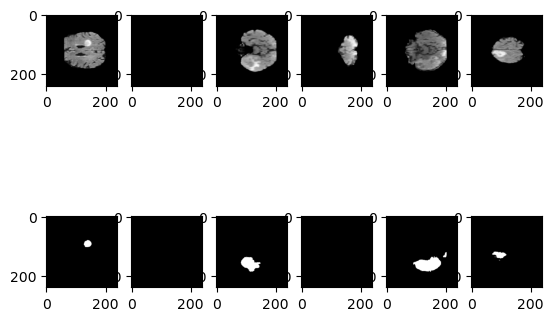

In [34]:
fig, axs = plt.subplots(2, 6)
for i in range(6):
    axs[0,i].imshow(images[i,0,:,:], cmap="gray")
    axs[1,i].imshow(labels[i,0,:,:],cmap="gray")

In [35]:

import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


In [36]:
num_epochs = 25
running_loss = 0.0
dice = DiceLoss()


for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    
    if epoch >= 5 :
        optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)
    if epoch >= 15 :
        optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)
    else :
        optimizer = torch.optim.Adam(unet.parameters(), lr=0.1)
        
    for i, data in tqdm( enumerate(training_loader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        output = unet(inputs)
        loss = dice(output, labels)
        print(loss)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            } 
        torch.save(checkpoint, 'checkpoint.pth')
    
    
        # accuracy
        #_, predicted = torch.max(output, y)
        #total_train += y.nelement()
        #correct_train += predicted.eq(y.data).sum().item()
        #train_accuracy = 100 * correct_train / total_train
        #avg_accuracy = train_accuracy / len(train_loader)  
        #,  "Training Accuracy: %d %%" % (train_accuracy)
    
    print("loss for epoch " + str(epoch) + ":  " + str(running_loss))


  0%|          | 0/25 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/home/theo/miniconda3/envs/biomed_ml/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.9714, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.9861, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.9503, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.9314, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.9533, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.9569, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.8650, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.8945, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.7368, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.7227, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.7644, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6467, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6995, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6375, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6615, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5508, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5731, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5879, device='cuda:0',

tensor(0.3594, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4562, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3645, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3677, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3887, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6485, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2819, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3764, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4495, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5057, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2730, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4312, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4118, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5736, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5059, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3434, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5427, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2554, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.4041, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4145, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2696, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4917, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6401, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5718, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.8003, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6432, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4106, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3672, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5180, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5014, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3042, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3642, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3166, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3711, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4338, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3429, device='cuda:0',

tensor(0.3120, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4057, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4406, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2328, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2393, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2730, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4573, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3706, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3066, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4730, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2565, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2816, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3750, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3814, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3350, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3442, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3331, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2865, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.4601, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4146, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6646, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2483, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3141, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5222, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3986, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4174, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3454, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3631, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2475, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3595, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3988, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.7727, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5509, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5160, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3596, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1946, device='cuda:0',

tensor(0.2470, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3058, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2897, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3169, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2847, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1961, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2859, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3198, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4520, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3407, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3879, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3534, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2311, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3480, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3524, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3185, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3724, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2444, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.3402, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2935, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2968, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3337, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5320, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3285, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3804, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3989, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1796, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5995, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2956, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3231, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4108, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2916, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2761, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2931, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2494, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3814, device='cuda:0',

tensor(0.5154, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4887, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2768, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5381, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4356, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3839, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3929, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2344, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2367, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3447, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3086, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3167, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5274, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3647, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4836, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3650, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4367, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1916, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.2296, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2919, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3783, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4307, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2521, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2761, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3135, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2616, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3004, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2714, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3374, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5568, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3105, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2791, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1578, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1874, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2504, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5189, device='cuda:0',

tensor(0.1335, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2070, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2721, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1387, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1499, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3624, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1579, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2854, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3592, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2653, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2816, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2355, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3153, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1888, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4045, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2092, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3151, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6070, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.2547, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2064, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3616, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3608, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3019, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2257, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3421, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2307, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2453, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4434, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1788, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2222, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2240, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2326, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2601, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2156, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2816, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2270, device='cuda:0',

tensor(0.2216, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1169, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2972, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1712, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2075, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2731, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1662, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3821, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1760, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2945, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2849, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2277, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1589, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1869, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2242, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2287, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3310, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1800, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.4693, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2462, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3260, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1561, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2394, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2327, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1920, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1795, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1895, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2660, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3785, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3003, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1910, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4244, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1715, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1576, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1536, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1290, device='cuda:0',

tensor(0.2324, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1441, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2675, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1069, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2255, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2497, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1651, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2268, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2415, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2090, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2143, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2068, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1514, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1665, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2313, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1751, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2418, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1470, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1892, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3636, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3040, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1502, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2138, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4392, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2425, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2840, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1502, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1870, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1794, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1806, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1200, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1707, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1782, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1821, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2121, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2482, device='cuda:0',

tensor(0.1503, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1805, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2132, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1920, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2184, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1168, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1226, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1674, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1461, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1159, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1706, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6374, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1503, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1320, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6302, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1776, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1816, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1513, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1140, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2507, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1220, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3524, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2483, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2035, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1426, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1492, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1875, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3084, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2733, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1947, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2190, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1103, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3250, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1797, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2533, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1397, device='cuda:0',

tensor(0.0988, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1254, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1645, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1531, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1672, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1688, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2053, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1481, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1459, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1534, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1644, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0724, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1554, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1076, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2387, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1886, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1519, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1254, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1583, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2256, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1877, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1889, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1324, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.7875, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1575, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1969, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2420, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1746, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1906, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1730, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1566, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1689, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1258, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1729, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1942, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1389, device='cuda:0',

tensor(0.1155, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1390, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2021, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1598, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1335, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1393, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1336, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0970, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2322, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1066, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1254, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1250, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2173, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2060, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2132, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1334, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1615, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1238, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1475, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1647, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1540, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1077, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1930, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1522, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4414, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1169, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1378, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1824, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2403, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1497, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1698, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1495, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1126, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1341, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1892, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2713, device='cuda:0',

tensor(0.2002, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1682, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1345, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1447, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2083, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1808, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1229, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1249, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1261, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2268, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2944, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1198, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1626, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1311, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1207, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1484, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1298, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2771, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1338, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1371, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1531, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1275, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2415, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1561, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2250, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1614, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0803, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1656, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1802, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2095, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1041, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1425, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1344, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2423, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1993, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1499, device='cuda:0',

tensor(0.1563, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1630, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1377, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1305, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1728, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1152, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1437, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1154, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1230, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1949, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1304, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1073, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1344, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0999, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2173, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1755, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1118, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1501, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1875, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1777, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1251, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1519, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1413, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1391, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1664, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1497, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1786, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1876, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1402, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1656, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2311, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1734, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2171, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1958, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1063, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2416, device='cuda:0',

tensor(0.1178, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1312, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1632, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1128, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2350, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2167, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1286, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2647, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1450, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1068, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0812, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1590, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0966, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1582, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1799, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1211, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1538, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0728, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1154, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1506, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1747, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1158, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0855, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1298, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1195, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1328, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1619, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1314, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0997, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1450, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0804, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1563, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1868, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1186, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1255, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1111, device='cuda:0',

tensor(0.2301, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1268, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0864, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1752, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1088, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1343, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1306, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1996, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2008, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0859, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0994, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1623, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2117, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1264, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1541, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1704, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1649, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1336, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1566, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0976, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2196, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1580, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1672, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2087, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1596, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0865, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1846, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1860, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1763, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1342, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1456, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2087, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1187, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1992, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1854, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1278, device='cuda:0',

tensor(0.1595, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1418, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2107, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1712, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2072, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1160, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1520, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1522, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1689, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0848, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1292, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1169, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1684, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0838, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1400, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1854, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1511, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1162, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.0828, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1309, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0967, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0800, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1010, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0993, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1053, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1077, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1127, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0892, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0831, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1047, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1052, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1339, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1154, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1275, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1371, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1223, device='cuda:0',

tensor(0.1176, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1011, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1363, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0971, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1039, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0985, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0849, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1042, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1048, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1008, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0932, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1230, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0887, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1100, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1721, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1136, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1036, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0981, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.0985, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1119, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0871, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1151, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1193, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1098, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0904, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0862, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0951, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1129, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0925, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1527, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0844, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0828, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1357, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1131, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1066, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1061, device='cuda:0',

tensor(0.0900, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0898, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1065, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0837, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1040, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0785, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1106, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1380, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1175, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1198, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0780, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0814, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0988, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1679, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0628, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1548, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1021, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1971, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1559, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0948, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1073, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1252, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0751, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1126, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0745, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1074, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0784, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1430, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1463, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0956, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0909, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1216, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1453, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0999, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1585, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0835, device='cuda:0',

tensor(0.0977, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0990, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0972, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1091, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1036, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0870, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1107, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1424, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0976, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1304, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2001, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0943, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0888, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0638, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0780, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0924, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0708, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0798, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1030, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0671, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1186, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1219, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0712, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0878, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0785, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0864, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0866, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2210, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1557, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0980, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0902, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0834, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1587, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1068, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1089, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1002, device='cuda:0',

tensor(0.1153, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1919, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1029, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1144, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1066, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0948, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1236, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1287, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1243, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0818, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0880, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0911, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0836, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1191, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1006, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1111, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0898, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1036, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1554, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1093, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0711, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0931, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1112, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1480, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1148, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1066, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1182, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0832, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1202, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0875, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0840, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1099, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0878, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0848, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0735, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0958, device='cuda:0',

tensor(0.1148, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1088, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0853, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0871, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1369, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0792, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0983, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1192, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1713, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0927, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0693, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0950, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1079, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0945, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1215, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1083, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1299, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2580, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.0763, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1293, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1033, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0957, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1181, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1138, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0899, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1151, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2075, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1395, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0694, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1192, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1008, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1202, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0868, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1081, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0918, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0829, device='cuda:0',

tensor(0.0762, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0997, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0975, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0966, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0659, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1103, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1238, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1014, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0713, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0868, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1096, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1145, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1058, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0921, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0841, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2014, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0881, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1374, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1132, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1263, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1139, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0887, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0779, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0893, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0736, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1040, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0771, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0937, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1020, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2078, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2877, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1485, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1088, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1510, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0851, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1385, device='cuda:0',

tensor(0.1156, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1262, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0718, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1004, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1091, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0784, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0830, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0924, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1244, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0769, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1314, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1150, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1090, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0754, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0861, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0730, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0793, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0865, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1097, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1052, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0890, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1081, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0820, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2013, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1503, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2836, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1822, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1719, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0951, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0894, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1011, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2481, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0888, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0947, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1072, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0974, device='cuda:0',

tensor(0.1173, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0749, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0793, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1363, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1064, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0983, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1087, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0997, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0982, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1180, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1340, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0860, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0792, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1065, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1454, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0788, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0980, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1218, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.0920, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0830, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1074, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0942, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0782, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1100, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0894, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0804, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0762, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0609, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0979, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0663, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1087, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1203, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1330, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1103, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1039, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1252, device='cuda:0',

tensor(0.0907, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1100, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1318, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0810, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1217, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1010, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0829, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1100, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1971, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1055, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1135, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1290, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1208, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0694, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1022, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1209, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0718, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2440, device='cuda:0',

0it [00:00, ?it/s]

tensor(0.1108, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1120, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0802, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1040, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1014, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1041, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0786, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1750, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0923, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0852, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1793, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1429, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1235, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0802, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0958, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0955, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0948, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1106, device='cuda:0',

tensor(0.0826, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0648, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0822, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0987, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0672, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0726, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0607, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1169, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0890, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1070, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0724, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0760, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0776, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3138, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1095, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1887, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0948, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0794, device='cuda:0',

In [37]:
torch.save(unet.state_dict(), "/home/theo/Documents/Biomedical/AI_biomed/checkpoint.pth")

In [38]:
train_features, train_labels = dataset[520]
train_features = train_features.to(device)
dataiter = iter(training_loader)
images, labels = next(dataiter)

images = images.to(device)

output = unet(images)
print(np.shape(output))
output_cpu = output.to("cpu")
images_cpu = images.to("cpu")
label_cpu = labels.to("cpu")

torch.Size([16, 1, 240, 240])


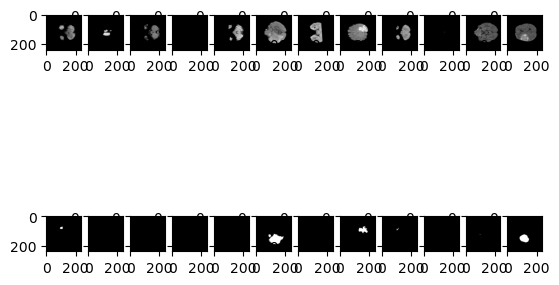

In [45]:
fig, axs = plt.subplots(2, 12)
for i in range(12):
    axs[0,i].imshow(images_cpu[i,0,:,:], cmap="gray")
    axs[1,i].imshow(label_cpu[i,0,:,:],cmap="gray")

torch.Size([16, 1, 240, 240])


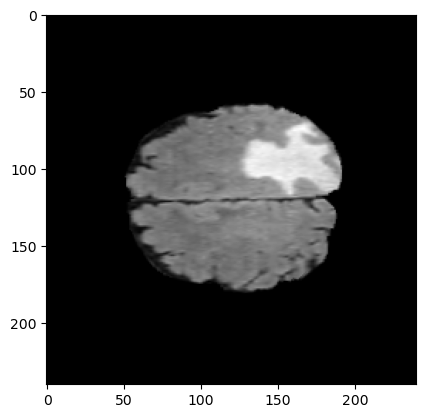

In [46]:
plt.imshow(images_cpu[7,0,:,:], cmap = "gray")
print(np.shape(labels))



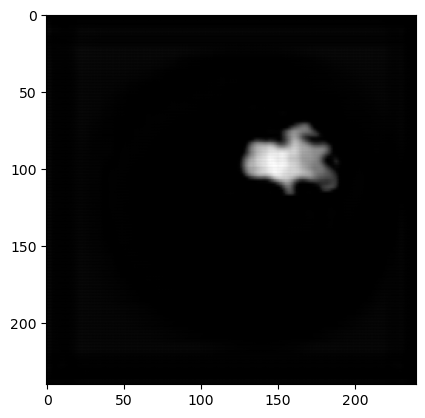

In [53]:
output2 =  output_cpu[7,0,:,:].detach().numpy()
plt.imshow(output2, cmap = "gray")